In [1]:
from pyspark.sql import SparkSession
from operator import add

# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.207:7077") \
        .appName("sentiment_analysis_group19")\
        .config("spark.executor.cores",2)\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", False)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

spark_context.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/23 14:42:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
# necessary imports
import time
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

# sentiment analysis libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Define sentiment analysis function

In [3]:
def analyze_sentiment(text):
    """Determines the sentiment of a given text. 
    Returns 0 if text sentiment is neither positive nor negative.
    Returns 1 if text sentiment is mainly positive
    Returns -1 if text sentiment is mainly negative. """
    try:
        sia = SentimentIntensityAnalyzer()
    except:
        nltk.download('vader_lexicon')
        sia = SentimentIntensityAnalyzer()
    try:
        scores = sia.polarity_scores(text)
    except: 
        pass
    pos = scores['pos']
    neg = scores['neg']
    if pos == neg:
        return 0
    elif pos > neg:
        return 1
    else:
        return -1

In [4]:
# check function
print(analyze_sentiment('I love you!'))
print(analyze_sentiment('I hate you..'))

1
-1


### Check how the sentiment of a post relates to it's score:
- Do posts with positive sentiment have a higher average score than negative posts?

In [5]:
def apply_sentiment_analysis(path):
    # read in data from path
    df = spark_session.read.json(path).cache()
    # select columns
    df = df.select('body', 'score')
    # instantiate user defined function
    analyze_sentiment_fct = udf(analyze_sentiment, IntegerType())
    # apply 'analyze_sentiment' on 'body and save result in column 'sentiment'
    df = df.withColumn('sentiment', analyze_sentiment_fct(df.body))
    
    # only consider posts with score larger than 10
    df = df.filter(df.score > 15)
    
    # posts with positive sentiment
    df_neg = df.filter(df.sentiment == -1)
    
    # posts with negative sentiment
    df_pos = df.filter(df.sentiment == 1)
    
    # num of posts with positive / negative sentiment
    num_neg = df_neg.count()
    num_pos = df_pos.count()
    print('num_neg ', num_neg)
    print('num_pos ', num_pos)
    
    # total score
    sum_score_neg = df_neg.groupBy().agg(F.sum('score')).collect()
    sum_score_pos = df_pos.groupBy().agg(F.sum('score')).collect()
    
    print('sum_score_neg ', sum_score_neg[0][0])
    print('sum_score_pos ', sum_score_pos[0][0])

    # average score per post for negative / positive sentiment
    avg_neg = abs(sum_score_neg[0][0])/num_neg
    avg_pos = abs(sum_score_pos[0][0])/num_pos
     
    return avg_neg, avg_pos

### Measure runtime

In [6]:
start_time = time.time()

path = "hdfs://192.168.2.207:9000/input/RC_2010-06"
avg_neg, avg_pos = apply_sentiment_analysis(path)

print("--- %s seconds ---" % (time.time() - start_time))


print('average score negative sentiment: ', avg_neg)
print('average score pos sentiment: ', avg_pos)

num_neg  42733
num_pos  55047


sum_score_neg  2104128
sum_score_pos  2697868
--- 1139.7152225971222 seconds ---
average score negative sentiment:  49.23894882175368
average score pos sentiment:  49.010263956255564


In [10]:
# file_1_path = "hdfs://192.168.2.207:9000/input/RC_2008-07"
# file_2_path = "hdfs://192.168.2.207:9000/input/RC_2009-05"
# file_3_path = "hdfs://192.168.2.207:9000/input/RC_2009-08"

# files = [file_1_path, file_2_path, file_3_path]

# for filepath in files:
#     start_time = time.time()
#     avg_neg, avg_pos = apply_sentiment_analysis(filepath)
#     print(filepath)
#     print('average score negative sentiment: ', avg_neg)
#     print('average score pos sentiment: ', avg_pos)    
#     print("--- %s seconds ---" % (time.time() - start_time))
#     print("\n")

### Plot Strong Scaling

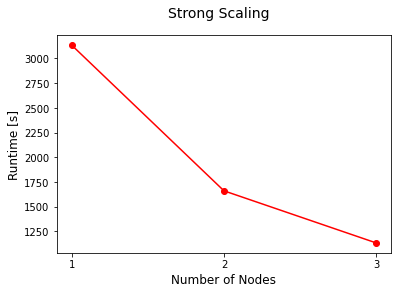

In [8]:
x = ['1','2','3']
y = [3134, 1661, 1134]


fig = plt.figure()
plt.plot(x, y,'ro-',label='line3')

plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Runtime [s]', fontsize=12)

fig.suptitle('Strong Scaling', fontsize=14)
fig.savefig('strong_scaling.jpg')

### Plot Weak Scaling

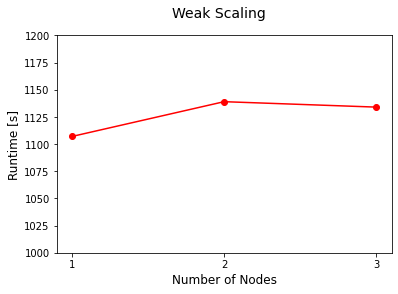

In [9]:
x = ['1','2','3']
y = [1107, 1139, 1134]


fig = plt.figure()
plt.plot(x, y,'ro-',label='line3')
plt.ylim([1000, 1200])

plt.xlabel('Number of Nodes', fontsize=12)
plt.ylabel('Runtime [s]', fontsize=12)

fig.suptitle('Weak Scaling', fontsize=14)
fig.savefig('weak_scaling.jpg')

In [19]:
spark_context.stop()